#cnn multilabel classification

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

In [ ]:
import urllib.request
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, RepeatedKFold
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#build directories
!mkdir /content/CIFAR-10
!mkdir /content/datasets
!mkdir /content/datasets/CIFAR-10
!mkdir /content/datasets/CIFAR-10/images
!mkdir /content/datasets/CIFAR-10/images/train
!mkdir /content/datasets/CIFAR-10/images/test

In [ ]:
#download dataset
thetarfile = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
ftpstream = urllib.request.urlopen(thetarfile)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall("/content/CIFAR-10")

In [ ]:
#change path if u want
path = "/content/CIFAR-10/cifar-10-batches-py"
save_path = "/content/datasets/CIFAR-10"

batch1 = f'{path}/data_batch_1'
batch2 = f'{path}/data_batch_2'
batch3 = f'{path}/data_batch_3'
batch4 = f'{path}/data_batch_4'
batch5 = f'{path}/data_batch_5'
test_batch = f'{path}/test_batch'
path_save_images_train = f'{save_path}/images/train'
path_save_images_test = f'{save_path}/images/test'
path_save_df = f'{save_path}'

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
batch_data_1 = unpickle(batch1)
batch_data_2 = unpickle(batch2)
batch_data_3 = unpickle(batch3)
batch_data_4 = unpickle(batch4)
batch_data_5 = unpickle(batch5)
test_data = unpickle(test_batch)

In [ ]:
data1 = batch_data_1[b'data']
data1 = data1.reshape(len(data1), 3,32,32).transpose(0, 2, 3, 1)
data2 = batch_data_2[b'data']
data2 = data2.reshape(len(data2), 3,32,32).transpose(0, 2, 3, 1)
data3 = batch_data_3[b'data']
data3 = data3.reshape(len(data3), 3,32,32).transpose(0, 2, 3, 1)
data4 = batch_data_4[b'data']
data4 = data4.reshape(len(data4), 3,32,32).transpose(0, 2, 3, 1)
data5 = batch_data_5[b'data']
data5 = data1.reshape(len(data5), 3,32,32).transpose(0, 2, 3, 1)
train = np.concatenate((data1, data2, data3, data4, data5))
test = test_data[b'data']
test = test.reshape(len(test), 3,32,32).transpose(0, 2, 3, 1)

In [ ]:
label1 = batch_data_1[b'labels']
label2 = batch_data_2[b'labels']
label3 = batch_data_3[b'labels']
label4 = batch_data_4[b'labels']
label5 = batch_data_5[b'labels']
test_label = test_data[b'labels']
train_label = np.concatenate((label1, label2, label3, label4, label5))

In [ ]:
label_mapper = {
0:"airplane",								
1:"automobile",									
2:"bird",									
3:"cat"	,									
4:"deer",									
5:"dog"	,									
6:"frog",										
7:"horse",										
8:"ship",										
9:"truck"}

In [ ]:
#train
df = pd.DataFrame()
# labels = []
for i in range(0, len(train)):
    image = Image.fromarray(train[i], 'RGB')
    label = train_label[i]
    original_name = label_mapper[label]
    name = label_mapper[label] + "_" + str(i)
    # labels.append(label)
    image.save(f"{path_save_images_train}/{name}.jpg")
    df = df.append({'ImageID':f'{name}', 'label':f'{original_name}'}, ignore_index = True)
df.to_csv(f"{path_save_df}/train.csv")

In [ ]:
#test
df = pd.DataFrame()
# labels = []
for i in range(0, len(test)):
    image = Image.fromarray(test[i], 'RGB')
    label = test_label[i]
    original_name = label_mapper[label]
    name = label_mapper[label] + "_" + str(i)
    # labels.append(label)
    image.save(f"{path_save_images_test}/{name}.jpg")
    df = df.append({'ImageID':f'{name}', 'label':f'{original_name}'}, ignore_index = True)
df.to_csv(f"{path_save_df}/test.csv")

In [ ]:
def multilabel_builder(path):
    df = pd.DataFrame()
    failed = []
    for img in os.listdir(path):
        img_name = img[:img.index("_")]
        if img_name == 'airplane':
            df = df.append({'id':img, 'class':img_name, 'vessel':1, 'animal':0, 'fly':1, 'walk':0, 'swim':0, 'jump':0}, ignore_index = True)
        elif img_name =='automobile':
             df = df.append({'id':img, 'class':img_name, 'vessel':1, 'animal':0, 'fly':0, 'walk':0, 'swim':0, 'jump':0}, ignore_index = True)
        elif img_name == 'bird':
             df = df.append({'id':img, 'class':img_name, 'vessel':0, 'animal':1, 'fly':1, 'walk':1, 'swim':0, 'jump':1}, ignore_index = True)
        elif img_name == 'cat':
             df = df.append({'id':img, 'class':img_name, 'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
        elif img_name == 'deer':
             df = df.append({'id':img, 'class':img_name, 'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
        elif img_name == 'dog':
             df = df.append({'id':img, 'class':img_name, 'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
        elif img_name == 'frog':
             df = df.append({'id':img, 'class':img_name, 'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
        elif img_name == 'horse':
             df = df.append({'id':img, 'class':img_name, 'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
        elif img_name == 'ship':
             df = df.append({'id':img, 'class':img_name, 'vessel':1, 'animal':0, 'fly':0, 'walk':0, 'swim':1, 'jump':0}, ignore_index = True)
        elif img_name == 'truck':
             df = df.append({'id':img, 'class':img_name, 'vessel':1, 'animal':0, 'fly':0, 'walk':0, 'swim':0, 'jump':0}, ignore_index = True)
        else:
            print(f"Error image {img}!")
            failed.append(img)
    return df, failed


In [ ]:
train_df, failed_train = multilabel_builder(path_save_images_train)
test_df, failed_test = multilabel_builder(path_save_images_test)

In [ ]:
print(len(train_df))
train_df.head()

50000


,id,class,vessel,animal,fly,walk,swim,jump
0,bird_31280.jpg,bird,0.0,1.0,1.0,1.0,0.0,1.0
1,bird_10505.jpg,bird,0.0,1.0,1.0,1.0,0.0,1.0
2,dog_32946.jpg,dog,0.0,1.0,0.0,1.0,1.0,1.0
3,automobile_39936.jpg,automobile,1.0,0.0,0.0,0.0,0.0,0.0
4,bird_16695.jpg,bird,0.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
print(len(test_df))
test_df.head()

10000


,id,class,vessel,animal,fly,walk,swim,jump
0,automobile_9245.jpg,automobile,1.0,0.0,0.0,0.0,0.0,0.0
1,dog_679.jpg,dog,0.0,1.0,0.0,1.0,1.0,1.0
2,dog_7985.jpg,dog,0.0,1.0,0.0,1.0,1.0,1.0
3,automobile_439.jpg,automobile,1.0,0.0,0.0,0.0,0.0,0.0
4,automobile_7565.jpg,automobile,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df['class'].value_counts()

bird          5000
dog           5000
automobile    5000
cat           5000
airplane      5000
ship          5000
deer          5000
horse         5000
truck         5000
frog          5000
Name: class, dtype: int64

In [ ]:
test_df['class'].value_counts()

automobile    1000
dog           1000
horse         1000
deer          1000
truck         1000
bird          1000
cat           1000
ship          1000
frog          1000
airplane      1000
Name: class, dtype: int64

In [ ]:
from keras.preprocessing import image
def train_test_builder(df, path, SIZE = 32):
  X= []
  for i in tqdm(range(df.shape[0])):
    img = image.load_img(path + '/' + df['id'][i], target_size=(SIZE, SIZE))
    # img = path + '/' +  train_df['id'][i]
    img = image.img_to_array(img)
    X.append(img)
  
  #normalize
  X = tf.keras.utils.normalize(X, axis = 1)

  #make array
  X = np.array(X)
  
  #get labels
  y = np.array(df.drop(['id', 'class'], axis = 1))
  yclass = df['class'].values
  return X, y, yclass

In [ ]:
X_train, y_train, train_class = train_test_builder(train_df, path_save_images_train)
X_test, y_test, test_class = train_test_builder(test_df, path_save_images_test)

100%|██████████| 10000/10000 [00:02<00:00, 4196.00it/s]


In [ ]:
# X_train, y_train = shuffle(X_train, y_train)
# X_test, y_test = shuffle(X_test, y_test)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 6)
(10000, 32, 32, 3) (10000, 6)


In [ ]:
epochs = 50
activation = 'relu'
output_size = 6
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = activation, 
                 input_shape = (32, 32, 3)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())


model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))


model.add(Flatten())
model.add(Dense(512, activation = activation))
model.add(BatchNormalization())

model.add(Dense(output_size, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_34 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_35 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
history = model.fit(X_train, y_train, epochs = epochs)

Epoch 1/50
1563/1563 [==============================] - 14s 8ms/step - loss: 0.4060 - accuracy: 0.4093
Epoch 2/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3344 - accuracy: 0.4251
Epoch 3/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3054 - accuracy: 0.4308
Epoch 4/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2822 - accuracy: 0.4044
Epoch 5/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2612 - accuracy: 0.4139
Epoch 6/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2426 - accuracy: 0.4074
Epoch 7/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2250 - accuracy: 0.4194
Epoch 8/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2104 - accuracy: 0.4227
Epoch 9/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1965 - accuracy: 0.4012
Epoch 10/50
1563/1563 [==============================] - 13s 8ms/step - l

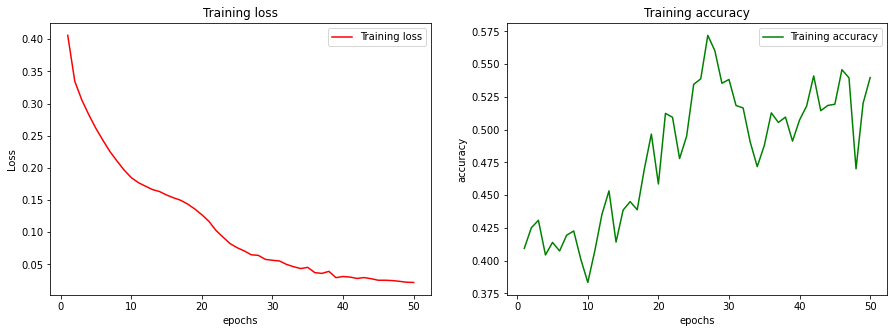

In [ ]:
f = plt.figure(figsize=(15,5))
f.add_subplot(1, 2, 1)
loss = history.history['loss']
epochs = range(1, len(loss) +1)
plt.plot(epochs, loss, 'r', label ='Training loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
f.add_subplot(1,2, 2)
accuracy = history.history['accuracy']
epochs = range(1, len(loss) +1)
plt.plot(epochs, accuracy, 'g', label ='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("/content/multitrain.jpg")
plt.show(block=True)


In [ ]:
preds = model.predict(X_test)

In [ ]:
result = []
for i in range(len(preds)):
  a = [i for i,v in enumerate(preds[i]) if v > 0.5]
  y_pred = [0] * 6
  for j in a:
    y_pred[j] = 1.0
  result.append(y_pred)
result = np.array(result)

In [ ]:
print(accuracy_score(y_test, result))

0.8632


In [ ]:
print(classification_report(y_test, result, target_names = ['vessel', 'animal', 'fly', 'walk', 'swim', 'jump']))

              precision    recall  f1-score   support

      vessel       0.95      0.93      0.94      4000
      animal       0.96      0.97      0.96      6000
         fly       0.77      0.78      0.78      2000
        walk       0.96      0.97      0.96      6000
        swim       0.91      0.92      0.91      6000
        jump       0.96      0.97      0.96      6000

   micro avg       0.93      0.94      0.94     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.93      0.94      0.94     30000
 samples avg       0.94      0.94      0.94     30000



In [ ]:
result_df = pd.DataFrame()
for i in range(len(y_test)):
  result_df = result_df.append({'true_class':test_class[i], 'true labels':y_test[i], 'predicted':result[i]}, ignore_index = True)

In [ ]:
result_df

,true_class,true labels,predicted
0,automobile,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,dog,"[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]"
2,dog,"[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]"
3,automobile,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,automobile,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...
9995,automobile,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9996,truck,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9997,dog,"[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]"
9998,deer,"[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]"


In [ ]:
# result_df.to_csv("/content/multilabelcsv.csv")

score is still good, because a lot of labels are the same. If we change for every animal besides frog swim to 0, we should get a lower score. RERUN for confirmation

In [ ]:
failed_classes = []
for i in range(len(result_df)):
  if all(result_df['true labels'][i] == result_df['predicted'][i]):
    continue
  else:
    failed_classes.append(result_df['true_class'][i])

In [ ]:
len(failed_classes)

1368

In [ ]:
Counter(failed_classes)

Counter({'airplane': 196,
         'automobile': 79,
         'bird': 354,
         'cat': 127,
         'deer': 82,
         'dog': 86,
         'frog': 80,
         'horse': 54,
         'ship': 186,
         'truck': 124})

In [ ]:
multilabel_confusion_matrix(y_test, result)

array([[[5823,  177],
        [ 266, 3734]],

       [[3734,  266],
        [ 178, 5822]],

       [[7539,  461],
        [ 433, 1567]],

       [[3735,  265],
        [ 177, 5823]],

       [[3467,  533],
        [ 491, 5509]],

       [[3731,  269],
        [ 177, 5823]]])

In [ ]:
labels = ['vessel', 'animal', 'fly', 'walk', 'swim', 'jump']

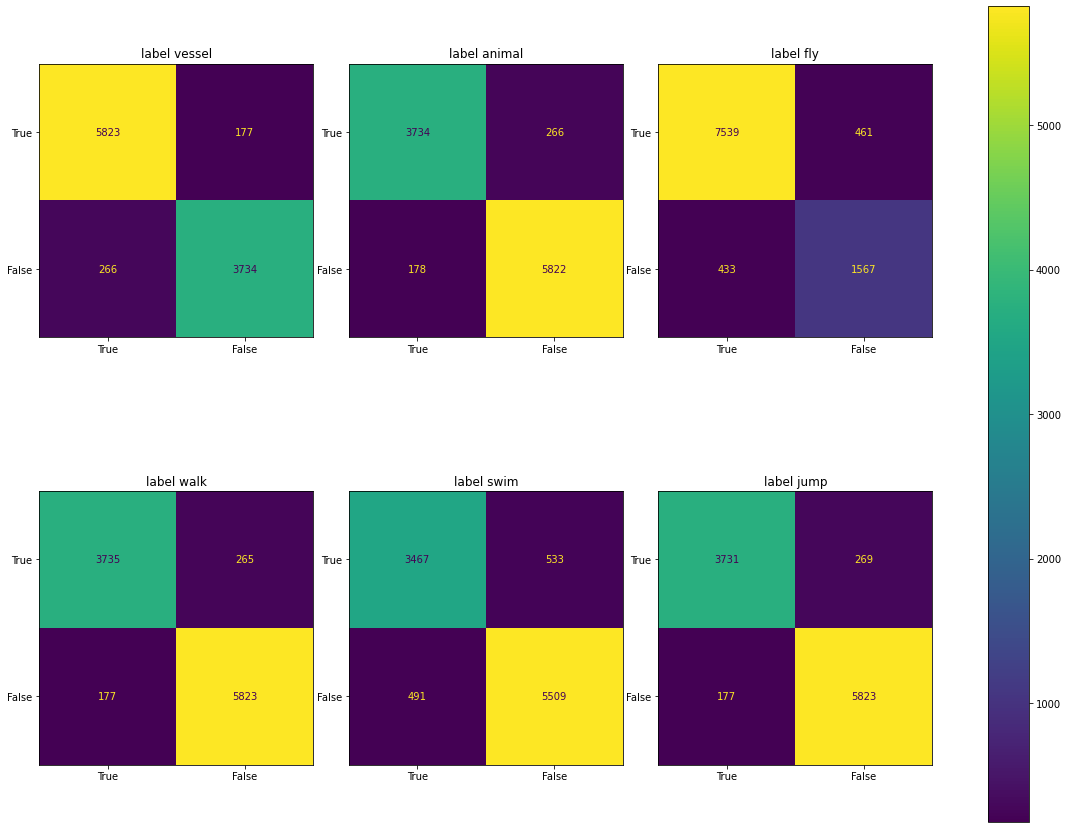

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   result[:, i]),
                                  display_labels=['True', 'False'])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'label {labels[i]}')
    # disp.ax_.set_ylabel('False True')
    # disp.ax_.set_xlabel('True False')
    # if i<10:
    disp.ax_.set_xlabel('')
    # if i%1!=0:
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.13, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.savefig("/content/confusionmatrix.jpg")
plt.show()


#cnn, multiclass classification

In [ ]:
label_mapper2 = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

In [ ]:
from keras.preprocessing import image
def train_test_builder(df, path, SIZE = 32, label_mapper = label_mapper2):
  X= []
  for i in tqdm(range(df.shape[0])):
    img = image.load_img(path + '/' + df['id'][i], target_size=(SIZE, SIZE))
    # img = path + '/' +  train_df['id'][i]
    img = image.img_to_array(img)
    X.append(img)
  
  #normalize
  X = tf.keras.utils.normalize(X, axis = 1)

  #make array
  X = np.array(X)
  
  #get labels
  y = np.array(df['class'].map(label_mapper2))
  y = tf.keras.utils.to_categorical(y)
  return X, y

In [ ]:
X_train, y_train = train_test_builder(train_df, path_save_images_train)
X_test, y_test = train_test_builder(test_df, path_save_images_test)

100%|██████████| 10000/10000 [00:02<00:00, 4339.13it/s]


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [ ]:
epochs = 50
activation = 'relu'
output_size = 10
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = activation, 
                 input_shape = (32, 32, 3)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())


model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))


model.add(Flatten())
model.add(Dense(512, activation = activation))
model.add(BatchNormalization())

model.add(Dense(output_size, activation = 'softmax'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_43 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_79 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_44 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
history = model.fit(X_train, y_train, epochs = epochs)

Epoch 1/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.6110 - accuracy: 0.4309
Epoch 2/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.2482 - accuracy: 0.5594
Epoch 3/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1174 - accuracy: 0.6074
Epoch 4/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0127 - accuracy: 0.6408
Epoch 5/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9139 - accuracy: 0.6764
Epoch 6/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8325 - accuracy: 0.7038
Epoch 7/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7485 - accuracy: 0.7338
Epoch 8/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6867 - accuracy: 0.7559
Epoch 9/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6335 - accuracy: 0.7745
Epoch 10/50
1563/1563 [==============================] - 12s 8ms/step - l

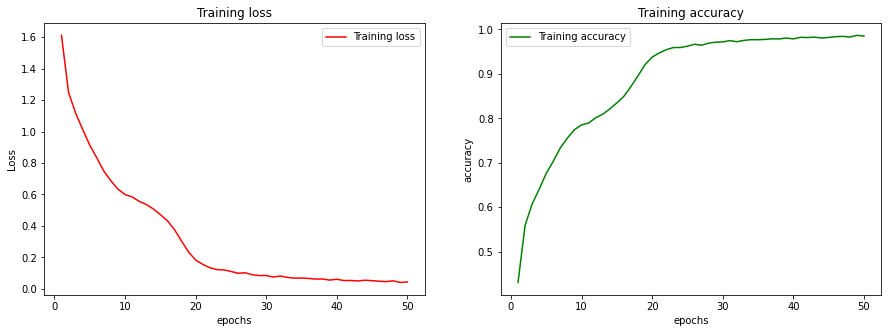

In [ ]:
f = plt.figure(figsize=(15,5))
f.add_subplot(1, 2, 1)
loss = history.history['loss']
epochs = range(1, len(loss) +1)
plt.plot(epochs, loss, 'r', label ='Training loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
f.add_subplot(1,2, 2)
accuracy = history.history['accuracy']
epochs = range(1, len(loss) +1)
plt.plot(epochs, accuracy, 'g', label ='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("/content/trainingmcc.jpg")
plt.show(block=True)

In [ ]:
preds = model.predict(X_test)  
y_pred = []
for i in range(len(preds)):
  y_pred.append(preds[i].argmax())
y_pred = np.array(y_pred)

In [ ]:
y_test_true = []
for i in range(len(y_test)):
  y_test_true.append(y_test[i].argmax())
y_test_true = np.array(y_test_true)

In [ ]:
print(accuracy_score(y_test_true, y_pred))

0.7513


In [ ]:
print(classification_report(y_test_true, y_pred, target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

              precision    recall  f1-score   support

    airplane       0.84      0.71      0.77      1000
  automobile       0.89      0.83      0.86      1000
        bird       0.62      0.69      0.66      1000
         cat       0.63      0.51      0.56      1000
        deer       0.68      0.73      0.71      1000
         dog       0.72      0.65      0.68      1000
        frog       0.72      0.85      0.78      1000
       horse       0.79      0.79      0.79      1000
        ship       0.84      0.87      0.85      1000
       truck       0.81      0.87      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [ ]:
def get_pred(prediction, test = test_df):
  df = pd.DataFrame()
  for i in range(len(prediction)):
    if prediction[i] == 0:
        df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'airplane', 
                        'vessel':1, 'animal':0, 'fly':1, 'walk':0, 'swim':0, 'jump':0}, ignore_index = True)
    elif prediction[i] == 1:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'automobile', 
                          'vessel':1, 'animal':0, 'fly':0, 'walk':0, 'swim':0, 'jump':0}, ignore_index = True)
    elif prediction[i] == 2:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'bird', 
                          'vessel':0, 'animal':1, 'fly':1, 'walk':1, 'swim':0, 'jump':1}, ignore_index = True)
    elif prediction[i] == 3:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'cat', 
                          'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
    elif prediction[i] == 4:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'deer', 
                          'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
    elif prediction[i] == 5:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'dog', 
                          'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
    elif prediction[i] == 6:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'frog', 
                          'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
    elif prediction[i] == 7:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'horse',  
                          'vessel':0, 'animal':1, 'fly':0, 'walk':1, 'swim':1, 'jump':1}, ignore_index = True)
    elif prediction[i] == 8:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'ship', 
                          'vessel':1, 'animal':0, 'fly':0, 'walk':0, 'swim':1, 'jump':0}, ignore_index = True)
    else:
          df = df.append({'id':test['id'][i], 'true_class':test['class'][i], 'predicted_class':'truck', 
                          'vessel':1, 'animal':0, 'fly':0, 'walk':0, 'swim':0, 'jump':0}, ignore_index = True)
  return df


In [ ]:
result_df = get_pred(y_pred)

In [ ]:
result_df.head()

,id,true_class,predicted_class,vessel,animal,fly,walk,swim,jump
0,automobile_9245.jpg,automobile,automobile,1.0,0.0,0.0,0.0,0.0,0.0
1,dog_679.jpg,dog,dog,0.0,1.0,0.0,1.0,1.0,1.0
2,dog_7985.jpg,dog,dog,0.0,1.0,0.0,1.0,1.0,1.0
3,automobile_439.jpg,automobile,truck,1.0,0.0,0.0,0.0,0.0,0.0
4,automobile_7565.jpg,automobile,automobile,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sum(np.where(result_df["true_class"] == result_df["predicted_class"], 1, 0))

7513

In [ ]:
failed_classes = []
for i in range(len(result_df)):
  if result_df['true_class'][i] == result_df['predicted_class'][i]:
    continue
  else:
    failed_classes.append(result_df['true_class'][i])

In [ ]:
Counter(failed_classes)

Counter({'airplane': 289,
         'automobile': 168,
         'bird': 305,
         'cat': 494,
         'deer': 266,
         'dog': 349,
         'frog': 147,
         'horse': 206,
         'ship': 134,
         'truck': 129})

In [ ]:
len(failed_classes)

2487

In [ ]:
result_df.true_class.unique()

array(['automobile', 'dog', 'horse', 'deer', 'truck', 'bird', 'cat',
       'ship', 'frog', 'airplane'], dtype=object)

In [ ]:
for i in result_df.true_class.unique():
  print('\033[1m' +i + '\033[0m')
  print(result_df[result_df.true_class ==i]['predicted_class'].value_counts())
  print(len(result_df[result_df.true_class ==i]['predicted_class']))
  print("\n")

automobile
automobile    832
truck          98
ship           31
frog           11
cat             7
airplane        6
dog             5
bird            4
horse           4
deer            2
Name: predicted_class, dtype: int64
1000


dog
dog           651
cat           113
bird           59
horse          57
deer           51
frog           43
ship           11
truck           7
airplane        5
automobile      3
Name: predicted_class, dtype: int64
1000


horse
horse         794
deer           55
bird           43
dog            32
cat            31
frog           18
airplane       12
truck           9
automobile      4
ship            2
Name: predicted_class, dtype: int64
1000


deer
deer          734
bird           75
horse          52
frog           47
cat            44
dog            20
ship           13
airplane        9
automobile      4
truck           2
Name: predicted_class, dtype: int64
1000


truck
truck         871
automobile     50
ship           18
cat            14
bird

In [ ]:
# result_df.to_csv("/content/prediction_test.csv")

###test scores

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # mit 256 layer -> 512 relu 100 epochen

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # mit 256 layer -> 512 sigmoid 20 epochen

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # mit 512 layer -> 1024 relu 20 epochen

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # mit 256 layer -> 512 relu 20 epochen

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # mit 128 layer -> 512 relu 20 epochen

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # mit 128 layer -> 256 relu 20 epochen

In [ ]:
print(accuracy_score(y_test_true, y_pred)) # ohne 128 -> 128 relu 20 epochen